# <img src="https://img.icons8.com/bubbles/50/000000/mind-map.png" style="height:50px;display:inline"> ECE 046211 - Technion - Deep Learning - Project
---

## "Mind the Gap" - A Deep Learning Analysis of Pothole Detection
---

|                  Name                     |      Campus Email              | Personal Email        |
|-------------------------------------------|--------------------------------|-----------------------|
|[Itai Benyamin](https://github.com/Itai-b) | itai.b@campus.technion.ac.il   |itai.benyamin@gmail.com|
|[Idan Baruch](https://github.com/idanbaru) | idan-b@campus.technion.ac.il   |idanb12200@gmail.com   |

## Imports

In [119]:
import os
import ast
import gc
import shutil
import xmltodict
import random
import numpy as np
import pandas as pd
import time
import copy
import re
from enum import Enum
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
import torchvision
import torchvision.models as models
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import kagglehub as kh
from tqdm import tqdm
from torchmetrics.detection import MeanAveragePrecision

# Set random seed for reproducibility
seed = 211
np.random.seed(seed)
torch.manual_seed(seed)

# Enable inline plotting for Jupyter notebooks
%matplotlib inline

# device - cpu or gpu?
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
pin_memory = True if device == "cuda:0" else False

print("pytorch version:", torch.__version__)
print("torchvision version:", torchvision.__version__)
print("Is CUDA available:", torch.cuda.is_available())
print("CUDA version:", torch.version.cuda)
print("PyTorch built with CUDA:", torch.backends.cuda.is_built())
print("Available devices:", torch.cuda.device_count())
print("Current device:", torch.cuda.get_device_name(torch.cuda.current_device()) if torch.cuda.is_available() else "No device")

pytorch version: 2.5.1
torchvision version: 0.20.1
Is CUDA available: True
CUDA version: 11.8
PyTorch built with CUDA: True
Available devices: 1
Current device: NVIDIA GeForce RTX 3090


## Data Loading

In [4]:
# Download the data using Kaggle API and save it to the data folder
kaggle_datapath = 'andrewmvd/pothole-detection'
data_path = 'data/andrewmvd_pothole_detection'
if not os.path.exists(data_path):
    #Load the data from kaggle
    data = kh.dataset_download(kaggle_datapath)
    # Move the data to the correct location
    shutil.move(data, data_path)
else:
    print('Data already exists')

Data already exists


In [52]:
class PotholeSeverity(Enum):
    """
    Enum class for the severity of potholes.
    The severity levels ranges from 0 (no pothole) to 4 (major pothole):
        0 - No pothole (background, shouldn't be a detection target)
        temporary 1 - general pothole, no specific severity)
        1 - Minor pothole (road damage that is non-dangerous for padestrians)
        2 - Medium pothole (road damage that is dangerous for padestrians, but not for vehicles)
        3 - Major pothole (road damage that is dangerous for both vehicles and padestrians)
    """
    NO_POTHOLE = 0
    POTHOLE = 1 # TODO - this label is for temporary until we classify each saverity in the data.
    #MINOR_POTHOLE = 1
    #MEDIUM_POTHOLE = 2
    #MAJOR_POTHOLE = 3

def get_label_name(label):
    return PotholeSeverity(label).name

class PotholeDetectionDataset:
    def __init__(self, img_dir, ann_dir, transform=None):
        self.img_dir = img_dir
        self.ann_dir = ann_dir
        self.transform = transform
        
        # Preprocess data
        self.img_files, self.ann_files = self._preprocess_dataset()

    
    @staticmethod
    def _extract_index(filename):
        # Use a regex to extract the numeric index from the file name
        match = re.search(r'\d+', filename)
        return int(match.group()) if match else float('inf')

    def _preprocess_dataset(self):
        # Get images from folder
        img_files = sorted(os.listdir(self.img_dir), key=self._extract_index)
        ann_files = sorted(os.listdir(self.ann_dir), key=self._extract_index)

        valid_img_files = []
        valid_ann_files = []

        # Parse images and annotated boxes to return only the valid images and boxes
        for img_file, ann_file in zip(img_files, ann_files):
            img_path = os.path.join(self.img_dir, img_file)
            ann_path = os.path.join(self.ann_dir, ann_file)
            
            # Load and validate
            img = cv2.imread(img_path)
            img_height, img_width = img.shape[:2]
            boxes, _ = self.parse_voc_annotation(ann_path)
            
            if self._check_boxes_validity(boxes, img_width, img_height):
                valid_img_files.append(img_file)
                valid_ann_files.append(ann_file)
                assert len(valid_img_files) == len(valid_ann_files)
        
        print(f'Number of valid images: {len(valid_img_files)}')
        return valid_img_files, valid_ann_files
    
    @staticmethod
    def _check_boxes_validity(boxes, img_width, img_height):
        for xmin, ymin, xmax, ymax in boxes:
            width = xmax - xmin
            height = ymax - ymin
            
            if width <= 0 or height <= 0:
                return False
            if xmin < 0 or ymin < 0 or xmax > img_width or ymax > img_height:
                return False
        return True

    def parse_voc_annotation(self, ann_path):
        with open(ann_path) as f:
            ann_data = xmltodict.parse(f.read())
        
        boxes = []
        labels = []
        objects = ann_data["annotation"].get("object", [])
        if not isinstance(objects, list):
            objects = [objects]
        
        for obj in objects:
            bbox = obj["bndbox"]
            xmin = int(float(bbox["xmin"]))
            ymin = int(float(bbox["ymin"]))
            xmax = int(float(bbox["xmax"]))
            ymax = int(float(bbox["ymax"]))
            boxes.append((xmin, ymin, xmax, ymax))
            labels.append(PotholeSeverity.POTHOLE.value)
        
        return boxes, labels
    
    def __len__(self):
        return len(self.img_files)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_files[idx])
        ann_path = os.path.join(self.ann_dir, self.ann_files[idx])
        
        # Load image
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        original_size = img.shape[:2]  # (height, width)
        
        # Load annotations
        boxes, labels = self.parse_voc_annotation(ann_path)
        
        # Apply transform
        if self.transform is not None:
            img_pil = torchvision.transforms.ToPILImage()(img)
            img = self.transform(img_pil)
            new_size = (img.shape[2], img.shape[1])  # (width, height)
            
            # Adjust bounding boxes
            orig_h, orig_w = original_size
            new_w, new_h = new_size
            x_scale = new_w / orig_w
            y_scale = new_h / orig_h
            boxes = [
                (int(xmin * x_scale), int(ymin * y_scale), int(xmax * x_scale), int(ymax * y_scale))
                for xmin, ymin, xmax, ymax in boxes
            ]
            
            target = {
                "boxes": torch.tensor(boxes, dtype=torch.float32),
                "labels": torch.tensor(labels, dtype=torch.int64),
                "image_id": torch.tensor([idx], dtype=torch.int64),
                "area": torch.tensor([(xmax - xmin) * (ymax - ymin) for xmin, ymin, xmax, ymax in boxes], dtype=torch.float32),
            }

        return img, target
    
# custom collate_fn for torch DataLoader
def collate_fn(batch):
    return tuple(zip(*batch))

In [53]:
# Paths to images and annotations
data_path = 'data/andrewmvd_pothole_detection'
img_dir = os.path.join(data_path,"images")
ann_dir = os.path.join(data_path,"annotations")

transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.ToTensor(), # uint8 values in [0, 255] -> float tensor with values [0, 1]
])

# Initialize the dataset
dataset = PotholeDetectionDataset(img_dir, ann_dir, transform=transform)

# Split the dataset to train, validation, and test sets (70-10-20)

# Maintain the original indices while splitting
train_indices, test_indices = train_test_split(range(len(dataset)), test_size=0.2, random_state=seed)
train_indices, val_indices = train_test_split(train_indices, test_size=0.125, random_state=seed)

train_set = Subset(dataset, train_indices)
val_set = Subset(dataset, val_indices)
test_set = Subset(dataset, test_indices)

print(f"Train set size: {len(train_set)} - {len(train_set)/len(dataset)*100:.2f}%")
print(f"Validation set size: {len(val_set)} - {len(val_set)/len(dataset)*100:.2f}%")
print(f"Test set size: {len(test_set)} - {len(test_set)/len(dataset)*100:.2f}%")


Number of valid images: 663
Train set size: 463 - 69.83%
Validation set size: 67 - 10.11%
Test set size: 133 - 20.06%


In [54]:
# normalize the images according to the mean and std of the training set
# DataLoader for train set
train_loader = DataLoader(train_set, batch_size=32, shuffle=False, num_workers=2, collate_fn=collate_fn)

# Initialize accumulators for mean and std
n_pixels = 0
mean_sum = torch.zeros(3)
squared_sum = torch.zeros(3)

for imgs, _ in train_loader:
    for img in imgs:
        img = img.view(3, -1)  # Flatten each channel
        n_pixels += img.size(1)  # Add the number of pixels per channel
        mean_sum += img.sum(dim=1)
        squared_sum += (img ** 2).sum(dim=1)

# Compute mean and std
mean = mean_sum / n_pixels
std = torch.sqrt(squared_sum / n_pixels - mean ** 2)

print(f"Training Set Mean: {mean}")
print(f"Training Set Std: {std}")

normalize = torchvision.transforms.Normalize(mean=mean.tolist(), std=std.tolist())

# Updated transforms
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.ToTensor(),
    normalize,
])

val_test_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.ToTensor(),
    normalize,
])

# Recreate datasets with the updated transforms
train_set.dataset.transform = train_transform
val_set.dataset.transform = val_test_transform
test_set.dataset.transform = val_test_transform

Training Set Mean: tensor([0.5279, 0.5176, 0.4970])
Training Set Std: tensor([0.1830, 0.1760, 0.1736])


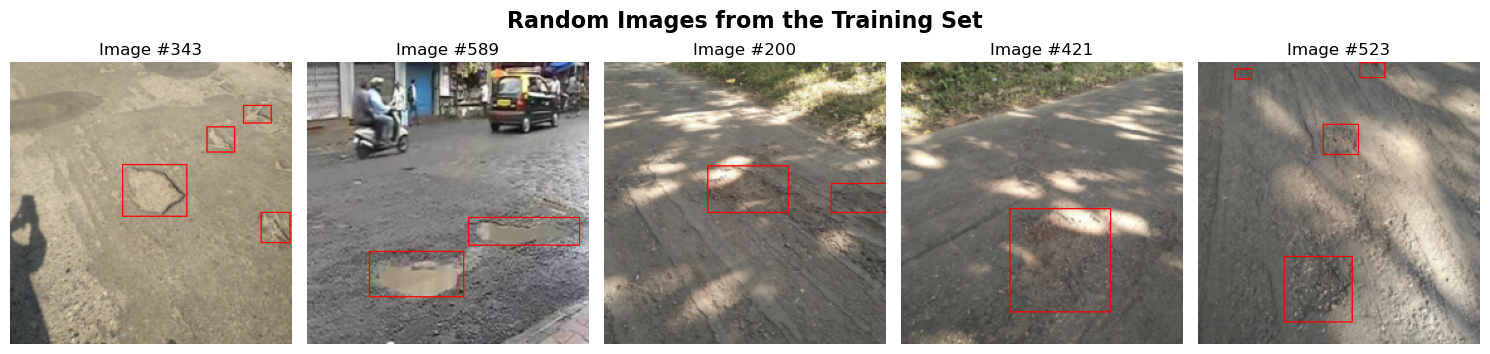

In [55]:
def convert_to_imshow_format(image, mean=mean, std=std):
    """
    Converts a normalized image tensor to the format expected by plt.imshow.
    Args:
        image (torch.Tensor): Normalized image tensor of shape [C, H, W].
        mean (torch.Tensor): Mean used for normalization (1D tensor of length 3 for RGB).
        std (torch.Tensor): Std used for normalization (1D tensor of length 3 for RGB).
    Returns:
        np.ndarray: Image array in HWC format, scaled to [0, 255] and uint8 type.
    """
    # Denormalize the image
    image = image * std[:, None, None] + mean[:, None, None]  # Reshape mean and std for broadcasting
    image = image.clamp(0, 1)  # Ensure values are in [0, 1] range
    
    # Convert to numpy and scale to [0, 255]
    image = (image.numpy() * 255).astype(np.uint8)
    
    # Convert from CHW to HWC
    return image.transpose(1, 2, 0)

# Display 5 random images from the training set
train_loader = DataLoader(train_set, batch_size=5, shuffle=True, collate_fn=collate_fn)
images, targets = next(iter(train_loader))

# Create a figure with subplots
fig, axes = plt.subplots(1, len(images), figsize=(15, 5))

for idx, (img, target) in enumerate(zip(images, targets)):
    # Convert image to imshow format
    img_np = convert_to_imshow_format(img, mean, std)
    img_np = np.ascontiguousarray(img_np)  # Ensure compatibility with OpenCV
    
    # Draw bounding boxes and labels
    for box, label in zip(target["boxes"], target["labels"]):
        cv2.rectangle(img_np,
                      (int(box[0]), int(box[1])),
                      (int(box[2]), int(box[3])),
                      (255, 0, 0), 1)  # Blue box with thickness 2
        # label_name = get_label_name(label.item())
        # cv2.putText(img_np,
        #             label_name,
        #             (int(box[0]), int(box[1] - 5)),
        #             cv2.FONT_HERSHEY_SIMPLEX,
        #             0.5,
        #             (255, 0, 0), 1)  # Blue text
    
    # Display the image
    axes[idx].imshow(img_np)
    axes[idx].axis("off")
    axes[idx].set_title(f"Image #{target['image_id'].item()}")

plt.suptitle("Random Images from the Training Set", fontsize=16, fontweight="bold", y=0.85)

plt.tight_layout()
plt.show()

## Two Stage Object Detector - Faster R-CNN

In [90]:
from typing import List, Tuple
from torch import Tensor

## clear memory
gc.collect()
torch.cuda.empty_cache()

# Define the model (load pretrained weights of Resnet50-FPN on COCO_V1 dataset)
model = models.detection.fasterrcnn_resnet50_fpn(weights=models.detection.FasterRCNN_ResNet50_FPN_Weights.COCO_V1)

# Replace the classifier with a single-class output
num_classes = len(PotholeSeverity)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)
print(model.rpn.compute_loss)


def custom_compute_loss(
    objectness: Tensor, pred_bbox_deltas: Tensor, labels: List[Tensor], regression_targets: List[Tensor]
) -> Tuple[Tensor, Tensor]:
    """
    Args:
        objectness (Tensor)
        pred_bbox_deltas (Tensor)
        labels (List[Tensor])
        regression_targets (List[Tensor])

    Returns:
        objectness_loss (Tensor)
        box_loss (Tensor)
    """
    sampled_pos_inds, sampled_neg_inds = model.rpn.fg_bg_sampler(labels)  # Access `fg_bg_sampler` from `model.rpn`
    sampled_pos_inds = torch.where(torch.cat(sampled_pos_inds, dim=0))[0]
    sampled_neg_inds = torch.where(torch.cat(sampled_neg_inds, dim=0))[0]

    sampled_inds = torch.cat([sampled_pos_inds, sampled_neg_inds], dim=0)

    objectness = objectness.flatten()

    labels = torch.cat(labels, dim=0)
    regression_targets = torch.cat(regression_targets, dim=0)

    box_loss = torchvision.ops.distance_box_iou_loss(
        pred_bbox_deltas[sampled_pos_inds],
        regression_targets[sampled_pos_inds],
        reduction="sum"
    ) / (sampled_inds.numel())

    objectness_loss = F.binary_cross_entropy_with_logits(objectness[sampled_inds], labels[sampled_inds])

    return objectness_loss, box_loss

#overload the compute_loss function
#model.rpn.compute_loss = custom_compute_loss
print(model.rpn.compute_loss)

# Move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


<bound method RegionProposalNetwork.compute_loss of RegionProposalNetwork(
  (anchor_generator): AnchorGenerator()
  (head): RPNHead(
    (conv): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
      )
    )
    (cls_logits): Conv2d(256, 3, kernel_size=(1, 1), stride=(1, 1))
    (bbox_pred): Conv2d(256, 12, kernel_size=(1, 1), stride=(1, 1))
  )
)>
<bound method RegionProposalNetwork.compute_loss of RegionProposalNetwork(
  (anchor_generator): AnchorGenerator()
  (head): RPNHead(
    (conv): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
      )
    )
    (cls_logits): Conv2d(256, 3, kernel_size=(1, 1), stride=(1, 1))
    (bbox_pred): Conv2d(256, 12, kernel_size=(1, 1), stride=(1, 1))
  )
)>


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [70]:
def calculate_iou(box1, box2):
    """
    Calculate Intersection over Union (IoU) between two bounding boxes.
    Args:
        box1 (list or np.array): [xmin, ymin, xmax, ymax]
        box2 (list or np.array): [xmin, ymin, xmax, ymax]
    Returns:
        float: IoU value
    """
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    inter_area = max(0, x2 - x1) * max(0, y2 - y1)
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])

    union_area = box1_area + box2_area - inter_area

    return inter_area / union_area if union_area > 0 else 0.0

def calculate_precision_recall(gt_boxes, pred_boxes, pred_scores, iou_threshold=0.5):
    """
    Calculate precision and recall for predictions at a specific IoU threshold.
    Args:
        gt_boxes (list of np.array): Ground truth bounding boxes.
        pred_boxes (list of np.array): Predicted bounding boxes.
        pred_scores (list of float): Confidence scores for predictions.
        iou_threshold (float): IoU threshold for true positives.
    Returns:
        list, list: Precision and recall values at each confidence threshold.
    """
    sorted_indices = np.argsort(-np.array(pred_scores))
    pred_boxes = [pred_boxes[i] for i in sorted_indices]
    pred_scores = [pred_scores[i] for i in sorted_indices]

    tp = np.zeros(len(pred_boxes))
    fp = np.zeros(len(pred_boxes))
    matched_gt = set()

    for i, pred_box in enumerate(pred_boxes):
        best_iou = 0
        best_gt_idx = -1
        for gt_idx, gt_box in enumerate(gt_boxes):
            if gt_idx in matched_gt:
                continue
            iou = calculate_iou(pred_box, gt_box)
            if iou > best_iou:
                best_iou = iou
                best_gt_idx = gt_idx

        if best_iou >= iou_threshold:
            tp[i] = 1
            matched_gt.add(best_gt_idx)
        else:
            fp[i] = 1

    cum_tp = np.cumsum(tp)
    cum_fp = np.cumsum(fp)

    precisions = cum_tp / (cum_tp + cum_fp + 1e-8)
    recalls = cum_tp / len(gt_boxes)

    return precisions, recalls

def calculate_ap(precisions, recalls):
    """
    Calculate Average Precision (AP) from precision-recall curve.
    Args:
        precisions (list): Precision values.
        recalls (list): Recall values.
    Returns:
        float: Average Precision.
    """
    recalls = np.concatenate([[0], recalls, [1]])
    precisions = np.concatenate([[0], precisions, [0]])

    for i in range(len(precisions) - 1, 0, -1):
        precisions[i - 1] = max(precisions[i - 1], precisions[i])

    indices = np.where(recalls[1:] != recalls[:-1])[0]
    ap = np.sum((recalls[indices + 1] - recalls[indices]) * precisions[indices + 1])
    return ap

def calculate_map(ground_truths, predictions, num_classes, iou_threshold=0.5):
    """
    Calculate mean Average Precision (mAP).
    Args:
        ground_truths (dict): Ground truth annotations {image_id: {"boxes": [...], "labels": [...]}}.
        predictions (dict): Predictions {image_id: {"boxes": [...], "scores": [...], "labels": [...]}}.
        num_classes (int): Total number of classes.
        iou_threshold (float): IoU threshold for true positives.
    Returns:
        float: mAP value.
    """
    ap_per_class = []

    for class_id in range(1, num_classes + 1):
        all_gt_boxes = []
        all_pred_boxes = []
        all_pred_scores = []

        for image_id in ground_truths:
            gt_boxes = [box for box, label in zip(ground_truths[image_id]["boxes"], ground_truths[image_id]["labels"]) if label == class_id]
            pred_boxes = [box for box, label in zip(predictions[image_id]["boxes"], predictions[image_id]["labels"]) if label == class_id]
            pred_scores = [score for score, label in zip(predictions[image_id]["scores"], predictions[image_id]["labels"]) if label == class_id]

            all_gt_boxes.extend(gt_boxes)
            all_pred_boxes.extend(pred_boxes)
            all_pred_scores.extend(pred_scores)

        precisions, recalls = calculate_precision_recall(all_gt_boxes, all_pred_boxes, all_pred_scores, iou_threshold)
        ap = calculate_ap(precisions, recalls)
        ap_per_class.append(ap)

    return np.mean(ap_per_class)

In [98]:
def preprocess_bbox(prediction, threshold=0.5):
    
    """Non-max suppression is the final step of these object detection algorithms and is 
       used to select the most appropriate bounding box for the object.
       The NMS takes two things into account
        -The objectiveness score is given by the model
        -The overlap or IOU of the bounding boxes"""
    
    processed_bbox={}
    
    boxes=prediction["boxes"][prediction["scores"]>=threshold]
    scores=prediction["scores"][prediction["scores"]>=threshold]
    labels=prediction["labels"][prediction["scores"]>=threshold]
    nms=torchvision.ops.nms(boxes,scores,iou_threshold=threshold)
            
    processed_bbox["boxes"]=boxes[nms]
    processed_bbox["scores"]=scores[nms]
    processed_bbox["labels"]=labels[nms]
    
    return processed_bbox

In [124]:
# compute the mean average precision of the validation/test batch
def evaluate_model(model, data_loader, threshold=0.5):
    model.eval()  # Ensure the model is in evaluation mode
    metric = MeanAveragePrecision(box_format='xyxy', class_metrics=True)
    metric.to(device)
    all_predictions = {}
    
    with torch.no_grad():
        for images, targets in data_loader:
            # Prepare images for inference
            inputs = [img.to(device) for img in images]
            
            # Run model inference
            outputs=model(inputs)
            
            results=[]
            for output in outputs:
                results.append(preprocess_bbox(output, threshold))
                
            # Collect predictions and ground truth
            for i, (output, target) in enumerate(zip(outputs, targets)):
                image_id = target["image_id"].item()
                gt_boxes = target["boxes"].cpu().numpy().tolist()
                
                predictions = [
                    (box.tolist(), label.item(), score.item())
                    for box, label, score in zip(output['boxes'], output['labels'], output['scores'])
                    if score >= threshold
                ]
                all_predictions[image_id] = predictions
            metric.update(results,targets)
            
    results=metric.compute()       
    return all_predictions, results

In [131]:
def evaluate_model(model, data_loader, threshold=0.5):
    metric=MeanAveragePrecision(box_format='xyxy',class_metrics=True)
    metric.to(device)
    
    all_predictions={}
    
    model.eval()
    with torch.no_grad():
        for imgs,targets in data_loader:
            imgs=[img.to(device) for img in imgs]
            targets=[{k:v.to(device) for (k,v) in d.items()} for d in targets]
            predictions=model(imgs)
            
            results=[]
            for prediction, target in zip(predictions, targets):
                image_id = target["image_id"].item()
                results.append(preprocess_bbox(prediction, threshold))
                all_predictions[image_id]=prediction
            metric.update(results,targets)
            
    results=metric.compute()
    return all_predictions, results

In [91]:
train_loader = DataLoader(
    train_set,
    batch_size=4,
    shuffle=True,
    collate_fn=collate_fn
)

val_loader = DataLoader(
    val_set,
    batch_size=4,
    shuffle=False,
    collate_fn=collate_fn
)

# Define optimizer and learning rate scheduler
# TODO - explain chosen hyperparameters
optimizer = torch.optim.SGD(
    model.parameters(),
    lr=0.005,
    momentum=0.9,
    weight_decay=0.0005
)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Training loop
# TODO - explain the trade-off between batch size and number of epochs
# TODO -add validation check
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for images, targets in train_loader:
        
        # Prepare inputs for the model
        images = [img.to(device) for img in images]

        # Convert relevant target values to device
        targets_to_device = []
        for target in targets:
            targets_to_device.append({
                'boxes': target['boxes'].to(device),
                'labels': target['labels'].to(device)
            })
    
        # Compute loss
        loss_dict = model(images, targets_to_device)
        losses = sum(loss for loss in loss_dict.values())
        epoch_loss += losses.item()
        
        # Backpropagation
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
    
    # Step the learning rate scheduler
    lr_scheduler.step()
    
    # Compute validation loss
    val_images, val_targets = next(iter(val_loader))
    _ , val_map = evaluate_model(model, val_images, val_targets)
    
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}, Validation mAP: {val_map:.4f}")

# Save the trained model
torch.save(model.state_dict(), "faster_rcnn_pothole.pth")
print("Model training complete. Saved as 'faster_rcnn_pothole.pth'.")

Epoch 1/10, Loss: 42.1977, Validation mAP: 0.4554
Epoch 2/10, Loss: 32.7220, Validation mAP: 0.4375
Epoch 3/10, Loss: 28.4246, Validation mAP: 0.4554
Epoch 4/10, Loss: 21.4039, Validation mAP: 0.4375
Epoch 5/10, Loss: 19.2010, Validation mAP: 0.4531
Epoch 6/10, Loss: 18.2111, Validation mAP: 0.4514
Epoch 7/10, Loss: 17.1786, Validation mAP: 0.4514
Epoch 8/10, Loss: 16.9050, Validation mAP: 0.4514
Epoch 9/10, Loss: 16.8890, Validation mAP: 0.4514
Epoch 10/10, Loss: 16.7548, Validation mAP: 0.4514
Model training complete. Saved as 'faster_rcnn_pothole.pth'.


In [126]:
def visualize_predictions(images, targets, all_predictions, mean, std, threshold=0.5, show_severity=False):
    """
    Display images with ground truth and predicted bounding boxes.
    """
    fig, axs = plt.subplots(1, len(images), figsize=(15, 5))

    for i, (img, target) in enumerate(zip(images, targets)):
        # Convert image to imshow format
        img_np = convert_to_imshow_format(img, mean, std)
        img_np = np.ascontiguousarray(img_np)  # Ensure compatibility with OpenCV
        
        # Draw ground truth boxes (red)
        for box in target["boxes"]:
            cv2.rectangle(img_np, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), (255, 0, 0), 1)
            cv2.putText(img_np, "GT", (int(box[0]), int(box[1] - 5)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)
        
        # Access predictions for the specific image_id
        predictions = all_predictions.get(target['image_id'].item(), {})
        if predictions:
            for box, label, score in zip(predictions["boxes"], predictions["labels"], predictions["scores"]):
                if score < threshold:
                    continue
                xmin, ymin, xmax, ymax = map(int, box)
                cv2.rectangle(img_np, (xmin, ymin), (xmax, ymax), (0, 255, 0), 1)
                if show_severity:
                    cv2.putText(img_np, 
                                f"P: {get_label_name(label)}: {score:.2f}", 
                                (xmin, ymin - 10), 
                                cv2.FONT_HERSHEY_SIMPLEX, 
                                0.5, 
                                (0, 255, 0), 2)  # Green text, thickness=2
                else:
                    cv2.putText(img_np, 
                                f"P: {score:.2f}", 
                                (xmin, ymax + 5), 
                                cv2.FONT_HERSHEY_SIMPLEX, 
                                0.5, 
                                (0, 255, 0), 1)
        
        # Display the image with annotations
        axs[i].imshow(img_np)
        axs[i].axis("off")
        axs[i].set_title(f"Image #{target['image_id'].item()}")

    # Add a main title
    plt.suptitle("Random Test Batch Predictions", fontsize=16, fontweight="bold", y=0.9)

    plt.tight_layout()
    plt.show()


Mean Average Precision[0.5:0.95:0.05] : 0.4009
Mean Average Precision @ 0.5          : 0.6842
Mean Average Precision @ 0.75         : 0.4388


ValueError: too many values to unpack (expected 3)

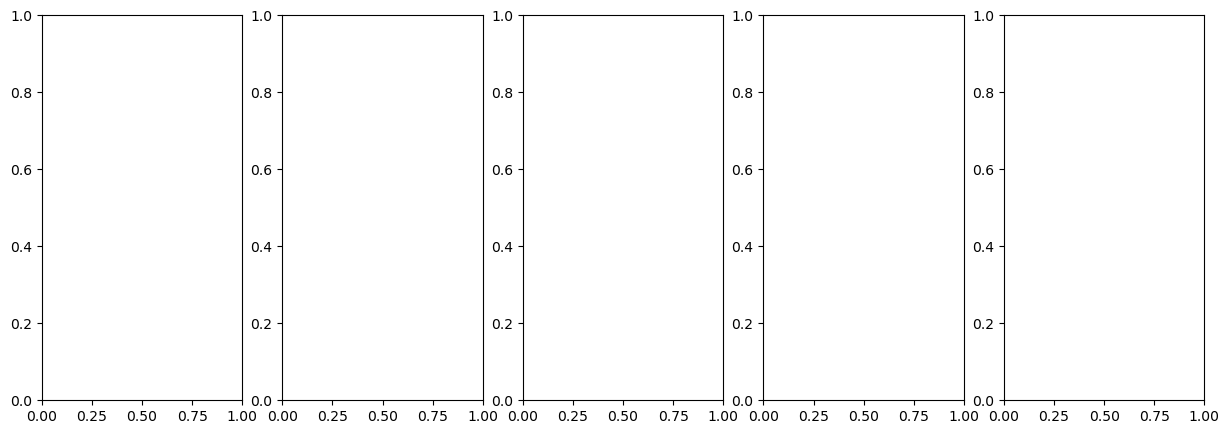

In [132]:
# Load the trained model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=None, num_classes=len(PotholeSeverity)) 
state_dict = torch.load("faster_rcnn_pothole_1.pth", weights_only=True)
model.load_state_dict(state_dict)
model.to(device)  # Move the model to the GPU
model.eval()  # Set the model to evaluation mode

# Define the TestLoader
test_loader = DataLoader(test_set, batch_size=5, shuffle=True, collate_fn=collate_fn)

# Evaluate the model on the random test batch
threshold = 0.5
predictions, results = evaluate_model(model, test_loader, threshold=threshold)

# Select a random batch
random_batch = random.choice(list(test_loader))  # Select a random batch
images, targets = random_batch

mean_ap=results["map"].item()
mean_ap_50=results["map_50"].item()
mean_ap_75=results["map_75"].item()

print(f"Mean Average Precision[0.5:0.95:0.05] : {mean_ap:.4f}")
print(f"Mean Average Precision @ 0.5          : {mean_ap_50:.4f}")
print(f"Mean Average Precision @ 0.75         : {mean_ap_75:.4f}")

visualize_predictions(images, targets,predictions, mean=mean, std=std, threshold=threshold, show_severity=False)

Mean Average Precision[0.5:0.95:0.05] : 0.4009
Mean Average Precision @ 0.5          : 0.6842
Mean Average Precision @ 0.75         : 0.4388


TypeError: '<' not supported between instances of 'str' and 'float'

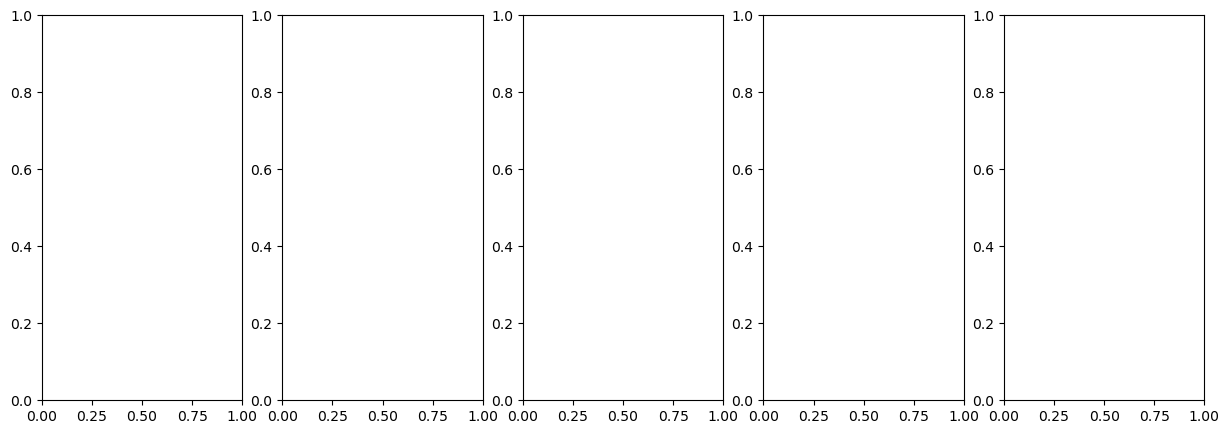

In [130]:
# Load the trained model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=None, num_classes=len(PotholeSeverity)) 
state_dict = torch.load("faster_rcnn_pothole_1.pth", weights_only=True)
model.load_state_dict(state_dict)
model.to(device)  # Move the model to the GPU
model.eval()  # Set the model to evaluation mode

test_loader = DataLoader(test_set, batch_size=5, shuffle=True, collate_fn=collate_fn)

predictions, results = evaluate_model(model, test_loader, threshold=0.5)

mean_ap=results["map"].item()
mean_ap_50=results["map_50"].item()
mean_ap_75=results["map_75"].item()

print(f"Mean Average Precision[0.5:0.95:0.05] : {mean_ap:.4f}")
print(f"Mean Average Precision @ 0.5          : {mean_ap_50:.4f}")
print(f"Mean Average Precision @ 0.75         : {mean_ap_75:.4f}")

# Select a random batch
random_batch = random.choice(list(test_loader))  # Select a random batch
images, targets = random_batch

visualize_predictions(images, targets, predictions, mean=mean, std=std, threshold=0.5, show_severity=False)